In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import constants as const
mpl.rcParams['figure.dpi'] = 120

## constants

In [2]:
k_gro = const.k * const.N_A * 1e-3
kBT = k_gro * 120.27239491968342
rho_0 = 0.8

## different k

In [19]:
k_fb = 0.5
#k_fb = 50  # for this one the theory fails, too large amplitude
perturbed_folder = f'perturbed-k{k_fb}/prod'

## import density profile

In [20]:
data = np.loadtxt('unperturbed/prod/density.xvg', comments=['@', '#'])
z = data.T[0]
rho = data.T[1]
delta_rho_0 = rho - rho_0

In [21]:
data = np.loadtxt(f'{perturbed_folder}/density.xvg', comments=['@', '#'])
z = data.T[0]
rho = data.T[1]
delta_rho = rho - rho_0

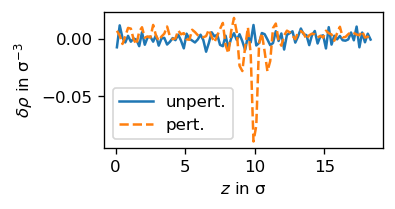

In [22]:
fig, ax = plt.subplots(figsize=(3, 1.5))
ax.plot(z, delta_rho_0, label='unpert.')
ax.plot(z, delta_rho, '--', label='pert.')
ax.set_xlabel(r'$z$ in σ')
ax.set_ylabel(r'$δρ$ in σ$^{-3}$')
ax.legend()
plt.show()

## define perturbation potential

In [23]:
# perturbing potential φ(z)
r_fb = -2
ref_fb = 10
d_fb = np.abs(z - ref_fb)
delta_phi = 1/2 * k_fb * (d_fb - np.abs(r_fb))**2 * np.heaviside(-(d_fb - np.abs(r_fb)), 0)

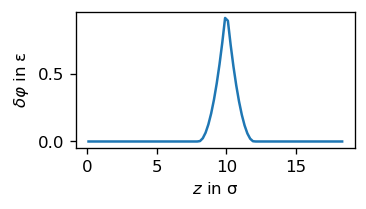

In [24]:
fig, ax = plt.subplots(figsize=(3, 1.5))
ax.plot(z, delta_phi)
ax.set_xlabel(r'$z$ in σ')
ax.set_ylabel(r'$δφ$ in ε')
plt.show()

## import rdf

In [25]:
#data, _ = gt.xvg.load('unperturbed/prod/rdf.xvg')
data = np.loadtxt('unperturbed/prod/rdf.xvg', comments=['@', '#'])
r = data.T[0]
g = data.T[1]

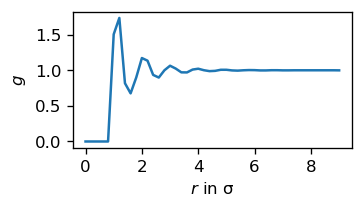

In [26]:
fig, ax = plt.subplots(figsize=(3, 1.5))
ax.plot(r, g)
ax.set_xlabel(r'$r$ in σ')
ax.set_ylabel(r'$g$')
plt.show()

## structure factor

In [27]:
def fourier_radsym(r, y, k):
    """ Fourier transform over radial symetric function in R3 """
    Delta_r = r[1] - r[0]
    y_hat = np.zeros_like(k, dtype=np.complex)
    with np.errstate(divide='ignore', invalid='ignore', under='ignore'):
        for i, k_i in enumerate(k):
            y_hat[i] = (2 / k_i * Delta_r
                        * np.sum(r * y * np.sin(2 * np.pi * k_i * r)))
    return y_hat

In [28]:
k_r = np.arange(1, len(r)) / (2 * max(r))
S = 1 + rho_0 * fourier_radsym(r, g - 1, k_r)

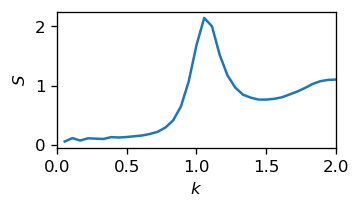

In [29]:
fig, ax = plt.subplots(figsize=(3, 1.5))
ax.plot(k_r, np.abs(S))
ax.set_xlim(0, 2)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$S$')
plt.show()

## *δφ* in Fourier space

In [30]:
k = np.fft.rfftfreq(len(z), z[1] - z[0])
#delta_rho_k = np.fft.rfft(delta_rho)
delta_phi_k = np.fft.rfft(delta_phi)
delta_phi_k[1]

(-6.311191145403924+1.5128476448489927j)

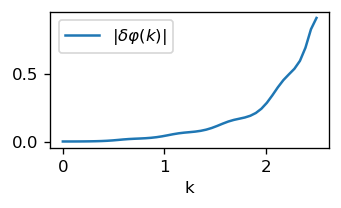

In [31]:
fig, ax = plt.subplots(figsize=(3, 1.5))
ax.plot(k, 0.01 / np.abs(delta_phi_k), label=r'$|δφ(k)|$')
#ax.set_xlim(0, 2)
ax.set_xlabel('k')
ax.legend()
plt.show()

In [32]:
# interpolate S
S_interp = np.interp(k, k_r, S)

In [33]:
# predict δρ(r)
rho_predicted_k = -delta_phi_k * (rho_0 * S_interp / kBT)
rho_predicted = np.fft.irfft(rho_predicted_k)

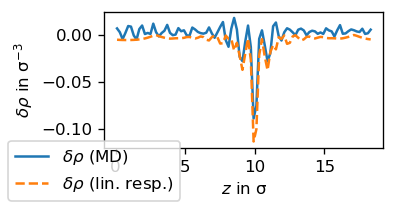

In [34]:
fig, ax = plt.subplots(figsize=(3, 1.5))
ax.plot(z, delta_rho, label=r'$δρ$ (MD)')
ax.plot(z, -np.abs(rho_predicted), '--', label=r'$δρ$ (lin. resp.)')
ax.set_xlabel(r'$z$ in σ')
ax.set_ylabel(r'$δρ$ in σ$^{-3}$')
fig.legend(loc='lower left')
plt.show()